## **Tujuan:** Menganalisis performa model `model_transfer_learning_TERBAIK.keras` secara objektif menggunakan data *test* yang belum pernah dilihat sebelumnya.

**Target Laporan (BAB IV):**
1.  Menampilkan grafik history training.
2.  Menghitung dan menampilkan metrik evaluasi (Akurasi, Presisi, Recall, F1-Score).
3.  Menampilkan Confusion Matrix.
4.  Menganalisis beberapa contoh prediksi yang benar dan salah.

**Prasyarat:**
* `plot_history_transfer_learning.png` (Sudah ada di Google Drive)
* `model_transfer_learning_TERBAIK.keras` (Sudah ada di Google Drive)


In [1]:
# Import Library
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display

## 1. Setup Awal: Hubungkan Drive dan Tentukan Path

Kita perlu menghubungkan ke Google Drive untuk mengambil model yang sudah disimpan dan data training. Kita juga akan mendefinisikan ulang path dan generator, terutama `test_generator`.


In [ ]:
# --- Hubungkan Google Drive ---
print("Menghubungkan ke Google Drive...")
drive.mount('/content/drive')
print("Google Drive terhubung.")

# --- Path dari Google Drive (Hasil Training) ---
BASE_DRIVE_PATH = "/content/drive/MyDrive/ProyekBatik"
MODEL_TERBAIK_PATH = os.path.join(BASE_DRIVE_PATH, "model_transfer_learning_TERBAIK.keras")
HISTORY_PLOT_PATH = os.path.join(BASE_DRIVE_PATH, "plot_history_transfer_learning.png")
CM_PLOT_PATH = os.path.join(BASE_DRIVE_PATH, "confusion_matrix_transfer_learning.png")
REPORT_PATH = os.path.join(BASE_DRIVE_PATH, "classification_report_transfer_learning.txt")

# --- Path dari Colab Runtime (Data Mentah) ---
# SANGAT PENTING: Pastikan sudah meng-unzip data Anda ke path ini
BASE_DATASET_PATH = "/content/dataset/dataset_batik_fix"
PROCESSED_DATA_PATH = os.path.join(BASE_DATASET_PATH, 'processed_dataset')
test_dir = os.path.join(PROCESSED_DATA_PATH, 'test') # Kita hanya butuh data tes

# --- Parameter yang Konsisten dari Training ---
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32 # Gunakan batch size yang sama saat evaluasi

print(f"Model akan dimuat dari: {MODEL_TERBAIK_PATH}")
print(f"Data tes akan dibaca dari: {test_dir}")


Menghubungkan ke Google Drive...
Mounted at /content/drive
Google Drive terhubung.
Model akan dimuat dari: /content/drive/MyDrive/ProyekBatik/model_transfer_learning_TERBAIK.keras
Data tes akan dibaca dari: /content/dataset/dataset_batik_fix/processed_dataset/test


## 2. Buat Ulang Test Generator

Kita harus membuat ulang `test_generator` persis seperti saat training untuk memastikan data dievaluasi dengan benar (terutama `preprocessing_function` dan `shuffle=False`).


In [14]:
# SEL 4.5: Instal GDown dan Impor ZipFile
print("Menginstal gdown (untuk download) dan mengimpor zipfile (untuk ekstrak)...")
!pip install -q gdown
import zipfile
print("Selesai.")

Menginstal gdown (untuk download) dan mengimpor zipfile (untuk ekstrak)...
Selesai.


In [15]:
# SEL 5: Download & Ekstrak Dataset dari Google Drive

print("Memulai proses download dan ekstraksi...")

# File ID dari Google Drive
file_id = "19GWEC95BAftlFKOsSztSCUk76ceTlVlt" # <-- ID file zip Anda
output_zip = "dataset_batik_fix.zip"
extract_path = "/content/dataset/" # Lokasi ekstrak di Colab runtime

# Gunakan format URL terbaru + opsi --fuzzy
gdrive_url = f"https://drive.google.com/uc?id={file_id}"
print("Mengunduh dataset dari Google Drive...")
!gdown --fuzzy "{gdrive_url}" -O "{output_zip}"

# Pastikan file berhasil diunduh
if not os.path.exists(output_zip):
    raise FileNotFoundError(
        f"Gagal mengunduh '{output_zip}'. "
        "Periksa apakah file di Google Drive sudah diset ke 'Siapa pun dengan tautan dapat melihat'."
    )

# Buat folder tujuan dan ekstrak dataset
os.makedirs(extract_path, exist_ok=True)
print(f"Mengekstrak '{output_zip}' ke '{extract_path}'...")

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Ekstraksi selesai! Dataset siap digunakan.")

Memulai proses download dan ekstraksi...
Mengunduh dataset dari Google Drive...
Downloading...
From (original): https://drive.google.com/uc?id=19GWEC95BAftlFKOsSztSCUk76ceTlVlt
From (redirected): https://drive.google.com/uc?id=19GWEC95BAftlFKOsSztSCUk76ceTlVlt&confirm=t&uuid=a9b46bbd-9f5a-46ef-846b-df03c7ba60f3
To: /content/dataset_batik_fix.zip
100% 2.09G/2.09G [00:35<00:00, 58.0MB/s]
Mengekstrak 'dataset_batik_fix.zip' ke '/content/dataset/'...
✅ Ekstraksi selesai! Dataset siap digunakan.


In [16]:
# Buat datagen HANYA untuk preprocessing, tanpa augmentasi
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Buat test_generator
# PENTING: shuffle=False agar urutan label (y_true) sesuai
print("Membuat generator data test...")
try:
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False # WAJIB False untuk evaluasi
    )

    # Dapatkan nama kelas
    class_names = list(test_generator.class_indices.keys())
    NUM_CLASSES = test_generator.num_classes

    print(f"Generator berhasil dibuat.")
    print(f"Total data tes: {test_generator.samples}")
    print(f"Ditemukan {NUM_CLASSES} kelas: {class_names}")

except FileNotFoundError:
    print(f"ERROR: Folder data tes tidak ditemukan di {test_dir}")
    print("Pastikan Anda sudah menjalankan sel unzip data dari notebook sebelumnya.")

Membuat generator data test...
Found 300 images belonging to 20 classes.
Generator berhasil dibuat.
Total data tes: 300
Ditemukan 20 kelas: ['batik_betawi', 'batik_bokor_kencono', 'batik_buketan', 'batik_dayak', 'batik_jlamprang', 'batik_kawung', 'batik_liong', 'batik_mega_mendung', 'batik_parang', 'batik_sekarjagad', 'batik_sidoluhur', 'batik_sidomukti', 'batik_sidomulyo', 'batik_singa_barong', 'batik_srikaton', 'batik_tribusono', 'batik_tujuh_rupa', 'batik_tuntrum', 'batik_wahyu_tumurun', 'batik_wirasat']


## 3. Muat Model dan Lakukan Evaluasi

Kita akan memuat model terbaik dan menjalankannya pada seluruh `test_generator` untuk mendapatkan metrik objektif.


In [17]:
# Muat model terbaik
print("Memuat model terbaik...")
model = tf.keras.models.load_model(MODEL_TERBAIK_PATH)
print("Model berhasil dimuat.")

Memuat model terbaik...
Model berhasil dimuat.


In [ ]:
# Langkah 1: Evaluasi cepat (Loss & Akurasi)
print("\nMengevaluasi model pada data tes...")
loss, accuracy = model.evaluate(test_generator)
print(f"\n--- Hasil Evaluasi Objektif ---")
print(f"Akurasi Data Tes: {accuracy * 100:.2f}%")   
print(f"Loss Data Tes: {loss:.4f}")



Mengevaluasi model pada data tes...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9472 - loss: 0.2280

--- Hasil Evaluasi Objektif ---
Akurasi Data Tes: 95.33%
Loss Data Tes: 0.2060


In [19]:
# Langkah 2: Prediksi penuh untuk metrik terperinci
print("\nMembuat prediksi untuk seluruh data tes...")
# Dapatkan label yang sebenarnya (Ground Truth)
y_true = test_generator.classes

# Dapatkan prediksi model
y_pred_probs = model.predict(test_generator)

# Ubah probabilitas -> ke kelas (indeks)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Prediksi selesai.")



Membuat prediksi untuk seluruh data tes...
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step
Prediksi selesai.


## 4. Draft Bab IV: Hasil dan Pembahasan

Bagian ini menyajikan semua temuan untuk dimasukkan ke dalam laporan.


### a. Hasil Training (Grafik Loss & Accuracy)

Grafik ini diambil dari file `.png` yang disimpan oleh notebook `03_Training_Baseline_Model.ipynb`.

Menampilkan Grafik History Training...


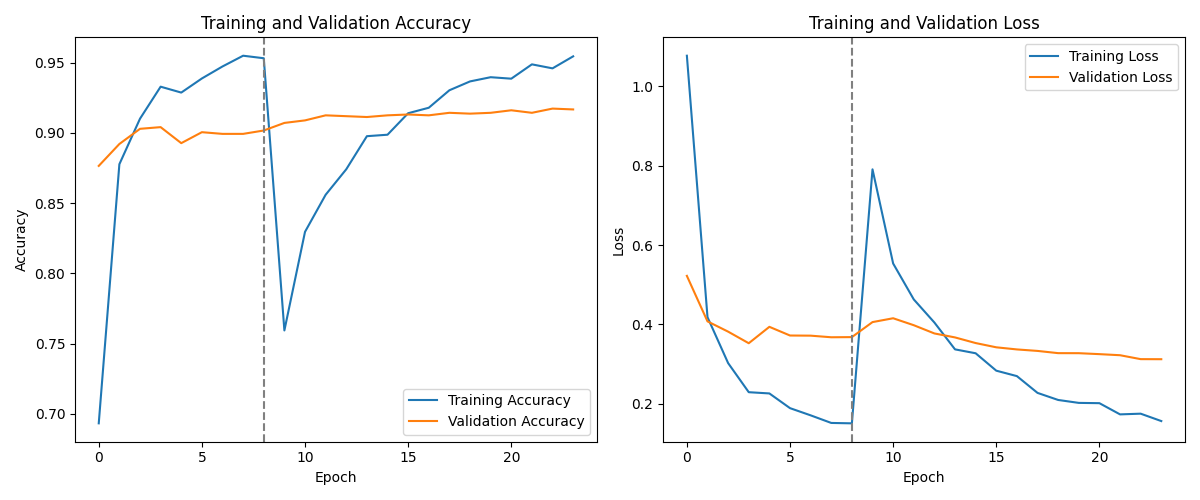

In [20]:
print("Menampilkan Grafik History Training...")
try:
    display(Image(filename=HISTORY_PLOT_PATH))
except FileNotFoundError:
    print(f"ERROR: File plot tidak ditemukan di {HISTORY_PLOT_PATH}")
    print("Pastikan file tersebut ada di Google Drive Anda.")

### b. Tabel Metrik Evaluasi (Akurasi, Presisi, Recall, F1-Score)

Metrik ini dihitung dari data tes dan menunjukkan seberapa baik performa model di setiap kelas.

In [21]:
print("--- Laporan Klasifikasi (Data Tes) ---")
# Menghasilkan laporan klasifikasi
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
print(report)


--- Laporan Klasifikasi (Data Tes) ---
                     precision    recall  f1-score   support

       batik_betawi      0.929     0.867     0.897        15
batik_bokor_kencono      1.000     1.000     1.000        15
      batik_buketan      0.933     0.933     0.933        15
        batik_dayak      1.000     1.000     1.000        15
    batik_jlamprang      1.000     0.800     0.889        15
       batik_kawung      0.789     1.000     0.882        15
        batik_liong      1.000     1.000     1.000        15
 batik_mega_mendung      0.933     0.933     0.933        15
       batik_parang      1.000     1.000     1.000        15
   batik_sekarjagad      1.000     1.000     1.000        15
    batik_sidoluhur      0.923     0.800     0.857        15
    batik_sidomukti      0.875     0.933     0.903        15
    batik_sidomulyo      0.882     1.000     0.938        15
 batik_singa_barong      1.000     1.000     1.000        15
     batik_srikaton      1.000     1.000     

### c. Confusion Matrix

Confusion matrix membantu kita melihat kelas mana yang sering tertukar oleh model.

Menampilkan Confusion Matrix...


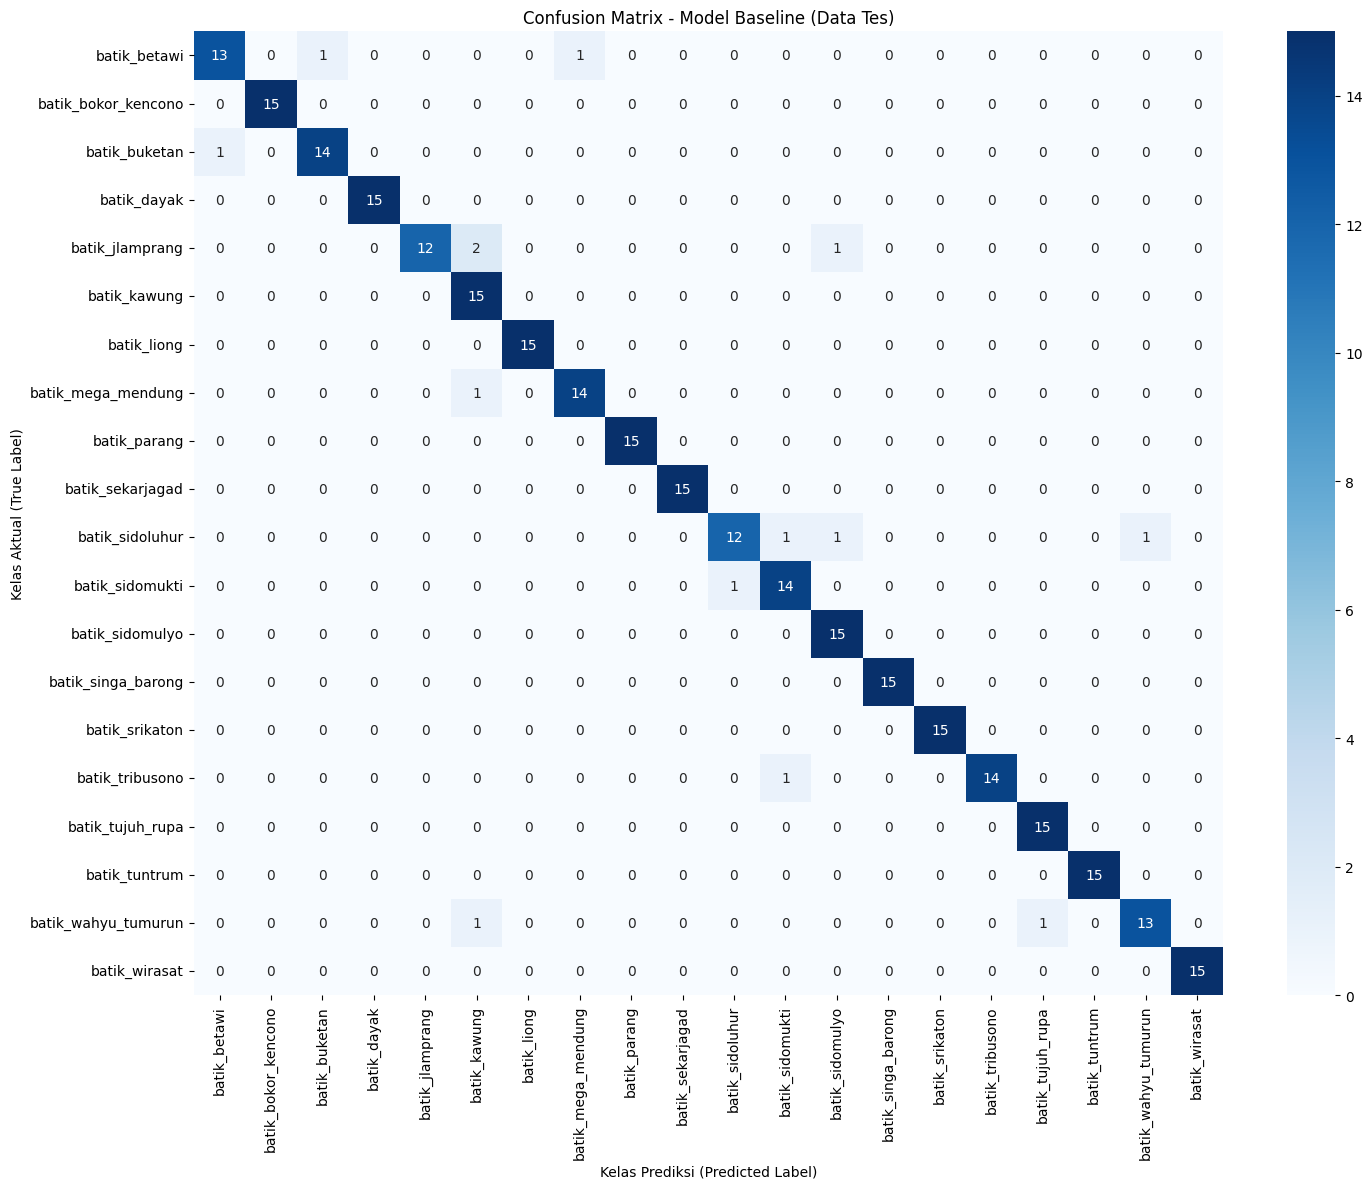

In [22]:
print("Menampilkan Confusion Matrix...")

# Buat Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasikan dengan Seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Model Baseline (Data Tes)')
plt.ylabel('Kelas Aktual (True Label)')
plt.xlabel('Kelas Prediksi (Predicted Label)')
plt.tight_layout()
plt.show()


### d. Pembahasan Performa Model (Contoh Teks Laporan)

*Berdasarkan hasil evaluasi, model baseline yang dilatih menggunakan arsitektur MobileNetV2... (lanjutkan pembahasan Anda)...*

* **Akurasi & Loss:** Model mencapai akurasi akhir pada data tes sebesar **{accuracy * 100:.2f}%** dengan loss **{loss:.4f}**. Hal ini menunjukkan... (bandingkan dengan akurasi validasi saat training)...*

* **Metrik Per Kelas (Tabel Laporan):** Dari tabel classification report, terlihat bahwa kelas... (cari kelas dengan F1-score tertinggi)... memiliki performa terbaik, sementara kelas... (cari kelas dengan F1-score terendah)... masih sulit untuk dikenali.*

* **Analisis Confusion Matrix:** Berdasarkan heatmap confusion matrix, kesalahan prediksi paling signifikan terjadi antara kelas... (cari kotak non-diagonal dengan angka tertinggi)... dan kelas... (contoh: model salah memprediksi 10 gambar 'Batik A' sebagai 'Batik B')... Hal ini mungkin disebabkan oleh... (kemiripan visual, jumlah data, dll)...*


## 5. Visualisasi Contoh Hasil Prediksi

Menganalisis secara manual beberapa gambar yang diprediksi benar dan salah oleh model untuk mendapatkan *insight* kualitatif.


--- MENCARI PREDIKSI BENAR ---


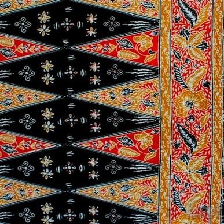

Gambar: batik_betawi/13 - Copy.jpg
Kelas Aktual:    **batik_betawi**
Kelas Prediksi:  **batik_betawi**
Keyakinan: 99.16%
HASIL: BENAR


In [23]:
from tensorflow.keras.preprocessing import image as krs_image

# Dapatkan daftar semua nama file
filenames = test_generator.filenames

# --- Cari 1 Contoh Prediksi BENAR ---
print("--- MENCARI PREDIKSI BENAR ---")
correct_found = False
for i in range(len(y_pred)):
    if y_pred[i] == y_true[i] and not correct_found:
        correct_found = True

        # Dapatkan path gambar
        img_path = os.path.join(test_dir, filenames[i])

        # Muat dan tampilkan gambar
        img = krs_image.load_img(img_path, target_size=IMG_SIZE)
        display(img)

        # Tampilkan hasil
        print(f"Gambar: {filenames[i]}")
        print(f"Kelas Aktual:    **{class_names[y_true[i]]}**")
        print(f"Kelas Prediksi:  **{class_names[y_pred[i]]}**")
        print(f"Keyakinan: {y_pred_probs[i][y_pred[i]] * 100:.2f}%")
        print("HASIL: BENAR")

if not correct_found:
    print("Tidak ditemukan contoh prediksi yang benar (ini aneh).")



--- MENCARI PREDIKSI SALAH ---


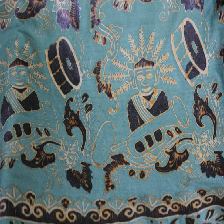

Gambar: batik_betawi/28.jpg
Kelas Aktual:    **batik_betawi**
Kelas Prediksi:  **batik_mega_mendung**
Keyakinan: 47.27%
HASIL: SALAH


In [ ]:
# --- Cari 1 Contoh Prediksi SALAH ---
print("\n--- MENCARI PREDIKSI SALAH ---")
wrong_found = False
for i in range(len(y_pred)):
    if y_pred[i] != y_true[i] and not wrong_found:
        wrong_found = True

        # Dapatkan path gambar
        img_path = os.path.join(test_dir, filenames[i])

        # Muat dan tampilkan gambar
        img = krs_image.load_img(img_path, target_size=IMG_SIZE)
        display(img)

        # Tampilkan hasil
        print(f"Gambar: {filenames[i]}")
        print(f"Kelas Aktual:    **{class_names[y_true[i]]}**")
        print(f"Kelas Prediksi:  **{class_names[y_pred[i]]}**")
        print(f"Keyakinan: {y_pred_probs[i][y_pred[i]] * 100:.2f}%")
        print("HASIL: SALAH")
        
if not wrong_found:
    print("Selamat! Tidak ditemukan kesalahan prediksi di seluruh data tes.")

---
**Evaluasi Selesai.**

Notebook ini telah menghasilkan semua metrik dan visualisasi yang diperlukan untuk Bab IV. Langkah selanjutnya adalah membangun UI Streamlit untuk demonstrasi model.
---
